In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense,AveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
# Initial parameters
epochs = 50
lr = 1e-3
batch_size = 64
img_dims = (96, 96, 3)
n_splits = 5  # K-folds
data = []
labels = []

In [3]:
# Load image files from the dataset
image_files = [f for f in glob.glob(r'gender_dataset_face/**/*', recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = 1 if label == "woman" else 0
    labels.append(label)

print(f"Loaded {len(data)} images with labels.")

Loaded 11135 images with labels.


In [5]:
# Preprocessing
data = np.array(data, dtype="float32")
data = preprocess_input(data)

labels = np.array(labels)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

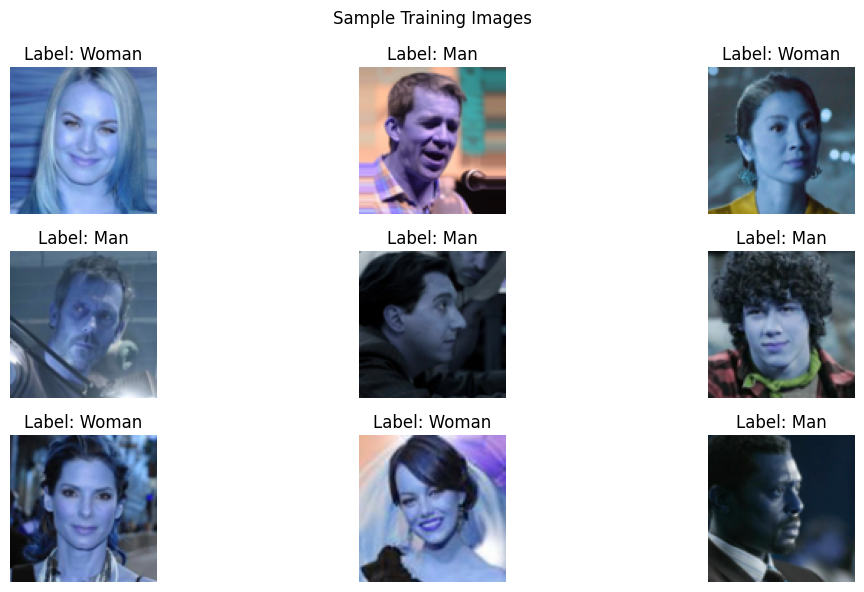

In [6]:
# Visualize sample images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(trainX) - 1)
    img = (trainX[idx] + 1) / 2.0  # Rescale from [-1, 1] to [0, 1] for display

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {'Woman' if np.argmax(trainY[idx]) == 1 else 'Man'}")
    plt.axis('off')

plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.savefig('Images/sample_images.png')
plt.show()

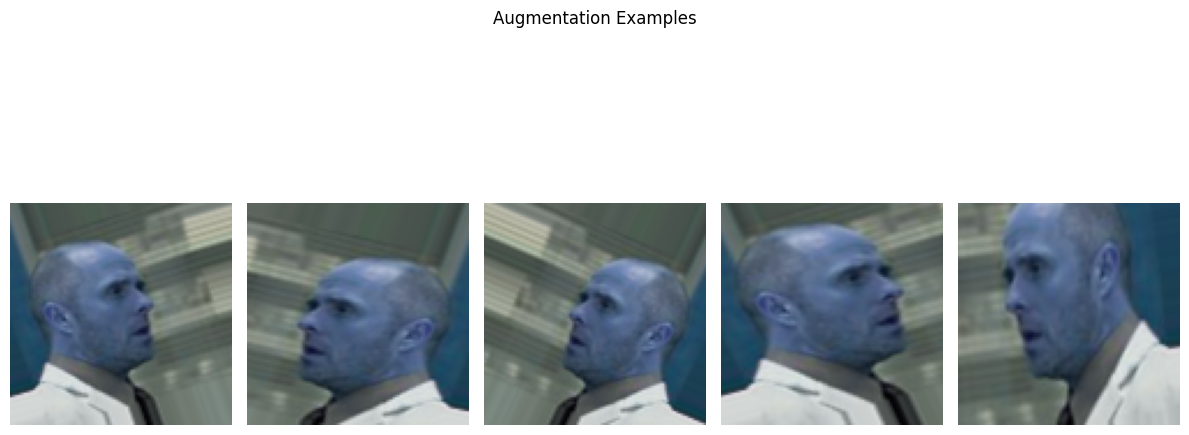

In [ ]:
# Augmenting the dataset
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)
# Visualize data augmentation
sample_image = trainX[0]
aug_iter = aug.flow(np.expand_dims(sample_image, axis=0), batch_size=1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    aug_image = next(aug_iter)[0]
    aug_image = (aug_image + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]
    plt.imshow(aug_image)
    plt.axis('off')

plt.suptitle("Augmentation Examples")
plt.tight_layout()
plt.savefig('Images/augmented_examples.png')
plt.show()

In [8]:
def build_mobilenet(input_shape=(96, 96, 3), classes=2):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False  # freeze base model

    x = base_model.output
    x = AveragePooling2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    opt = Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
# Train the model
# Stratified K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_accuracy = 0
best_model = None
best_fold = -1

for fold, (train_idx, test_idx) in enumerate(skf.split(data, labels)):
    print(f"\n===== Fold {fold + 1}/{n_splits} =====")
    trainX, testX = data[train_idx], data[test_idx]
    trainY, testY = labels[train_idx], labels[test_idx]

    trainY_cat = to_categorical(trainY, num_classes=2)
    testY_cat = to_categorical(testY, num_classes=2)

    # Build and compile the model
    model = build_mobilenet(input_shape=(img_dims[0], img_dims[1], 3))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    H=model.fit(
        aug.flow(trainX, trainY_cat, batch_size=batch_size),
        validation_data=(testX, testY_cat),
        steps_per_epoch=len(trainX) // batch_size,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate
    predY = model.predict(testX, batch_size=batch_size)
    predY = np.argmax(predY, axis=1)
    trueY = testY

    acc = accuracy_score(trueY, predY)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

    # Save the best model
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_fold = fold + 1

# Save the best model
best_model.save(f'Model/best_gender_detection_mobilenet_fold{best_fold}.h5')

# Final summary
print(f"\nBest Fold: {best_fold} with Accuracy: {best_accuracy:.4f}")


===== Fold 1/5 =====


C:\Users\Sayantan\AppData\Local\Temp\ipykernel_10948\574069573.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 366ms/step - accuracy: 0.7624 - loss: 0.5694 - val_accuracy: 0.8550 - val_loss: 0.3336
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.7500 - loss: 0.4248

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.7500 - loss: 0.4248 - val_accuracy: 0.8545 - val_loss: 0.3342
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 46s 328ms/step - accuracy: 0.8366 - loss: 0.3844 - val_accuracy: 0.8568 - val_loss: 0.3200
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8438 - loss: 0.2797 - val_accuracy: 0.8572 - val_loss: 0.3209
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 44s 317ms/step - accuracy: 0.8446 - loss: 0.3615 - val_accuracy: 0.8630 - val_loss: 0.3205
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8906 - loss: 0.3453 - val_accuracy: 0.8630 - val_loss: 0.3214
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 44s 319ms/step - accuracy: 0.8427 - loss: 0.3430 - val_accuracy: 0.8653 - val_loss: 0.3113
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8906 - loss: 0.3137 - val_accuracy: 0.8644 - val_loss: 0.3111
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - accuracy: 0.8477 - loss: 0.3489 - val_accurac

C:\Users\Sayantan\AppData\Local\Temp\ipykernel_10948\574069573.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_159']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 64s 398ms/step - accuracy: 0.7285 - loss: 0.6932 - val_accuracy: 0.8568 - val_loss: 0.3148
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 33s 242ms/step - accuracy: 0.7656 - loss: 0.4001

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.7656 - loss: 0.4001 - val_accuracy: 0.8590 - val_loss: 0.3155
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 365ms/step - accuracy: 0.8247 - loss: 0.3944 - val_accuracy: 0.8689 - val_loss: 0.2953
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.8750 - loss: 0.2696 - val_accuracy: 0.8689 - val_loss: 0.2958
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8283 - loss: 0.3741 - val_accuracy: 0.8689 - val_loss: 0.3010
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8281 - loss: 0.4246 - val_accuracy: 0.8657 - val_loss: 0.3017
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 49s 351ms/step - accuracy: 0.8288 - loss: 0.3747 - val_accuracy: 0.8725 - val_loss: 0.2972
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8594 - loss: 0.4529 - val_accuracy: 0.8738 - val_loss: 0.3004
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step
Fold 2 Accuracy: 0.8689

===== Fold 3/5 =====


C:\Users\Sayantan\AppData\Local\Temp\ipykernel_10948\574069573.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_318']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 66s 419ms/step - accuracy: 0.7422 - loss: 0.6347 - val_accuracy: 0.8604 - val_loss: 0.3219
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 34s 250ms/step - accuracy: 0.8438 - loss: 0.3141

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8438 - loss: 0.3141 - val_accuracy: 0.8590 - val_loss: 0.3217
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 370ms/step - accuracy: 0.8235 - loss: 0.3839 - val_accuracy: 0.8711 - val_loss: 0.3088
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7812 - loss: 0.4881 - val_accuracy: 0.8711 - val_loss: 0.3097
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 47s 335ms/step - accuracy: 0.8368 - loss: 0.3676 - val_accuracy: 0.8689 - val_loss: 0.3046
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8125 - loss: 0.4138 - val_accuracy: 0.8666 - val_loss: 0.3059
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 398ms/step - accuracy: 0.8407 - loss: 0.3576 - val_accuracy: 0.8747 - val_loss: 0.3021
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.7500 - loss: 0.5894 - val_accuracy: 0.8734 - val_loss: 0.3027
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 56s 400ms/step - accuracy: 0.8355 - loss: 0.3565 - val_accurac

C:\Users\Sayantan\AppData\Local\Temp\ipykernel_10948\574069573.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_477']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 496ms/step - accuracy: 0.7481 - loss: 0.6767 - val_accuracy: 0.8469 - val_loss: 0.3376
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 45s 329ms/step - accuracy: 0.7969 - loss: 0.4315

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.7969 - loss: 0.4315 - val_accuracy: 0.8482 - val_loss: 0.3348
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 62s 442ms/step - accuracy: 0.8269 - loss: 0.3904 - val_accuracy: 0.8478 - val_loss: 0.3437
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8594 - loss: 0.3612 - val_accuracy: 0.8482 - val_loss: 0.3382
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 60s 429ms/step - accuracy: 0.8399 - loss: 0.3659 - val_accuracy: 0.8473 - val_loss: 0.3289
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8438 - loss: 0.3127 - val_accuracy: 0.8469 - val_loss: 0.3305
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 61s 436ms/step - accuracy: 0.8447 - loss: 0.3611 - val_accuracy: 0.8581 - val_loss: 0.3141
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8281 - loss: 0.3275 - val_accuracy: 0.8590 - val_loss: 0.3128
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 423ms/step - accuracy: 0.8445 - loss: 0.3548 - val_acc

C:\Users\Sayantan\AppData\Local\Temp\ipykernel_10948\574069573.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_636']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 458ms/step - accuracy: 0.7427 - loss: 0.6443 - val_accuracy: 0.8541 - val_loss: 0.3240
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - accuracy: 0.9062 - loss: 0.3063

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9062 - loss: 0.3063 - val_accuracy: 0.8523 - val_loss: 0.3287
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 426ms/step - accuracy: 0.8202 - loss: 0.3861 - val_accuracy: 0.8657 - val_loss: 0.3185
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.7500 - loss: 0.4357 - val_accuracy: 0.8617 - val_loss: 0.3162
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 422ms/step - accuracy: 0.8334 - loss: 0.3671 - val_accuracy: 0.8662 - val_loss: 0.3153
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.8281 - loss: 0.3620 - val_accuracy: 0.8680 - val_loss: 0.3128
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 60s 428ms/step - accuracy: 0.8442 - loss: 0.3501 - val_accuracy: 0.8693 - val_loss: 0.3038
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.8438 - loss: 0.3626 - val_accuracy: 0.8698 - val_loss: 0.3025
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 424ms/step - accuracy: 0.8418 - loss: 0.3537 - val_acc

Fold 5 Accuracy: 0.8698

Best Fold: 3 with Accuracy: 0.8828


In [10]:
# Generate predictions
predY = best_model.predict(testX, batch_size=batch_size)  # Model predictions (probabilities)
predY = np.argmax(predY, axis=1)  # Convert probabilities to class labels
trueY = testY   # True labels (binary 0 or 1)

# Compute confusion matrix
cm = confusion_matrix(trueY, predY)

# Extract TP, FP, FN, TN
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix
print("Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

# Compute additional metrics
accuracy = accuracy_score(trueY, predY)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Classification report for more details
print("\nClassification Report:")
print(classification_report(trueY, predY, target_names=["Man", "Woman"]))


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step
Confusion Matrix:
[[1091   94]
 [ 176  866]]
True Positives (TP): 866
False Positives (FP): 94
False Negatives (FN): 176
True Negatives (TN): 1091
Accuracy: 0.88
Precision: 0.90
Recall: 0.83
F1 Score: 0.87

Classification Report:
              precision    recall  f1-score   support

         Man       0.86      0.92      0.89      1185
       Woman       0.90      0.83      0.87      1042

    accuracy                           0.88      2227
   macro avg       0.88      0.88      0.88      2227
weighted avg       0.88      0.88      0.88      2227



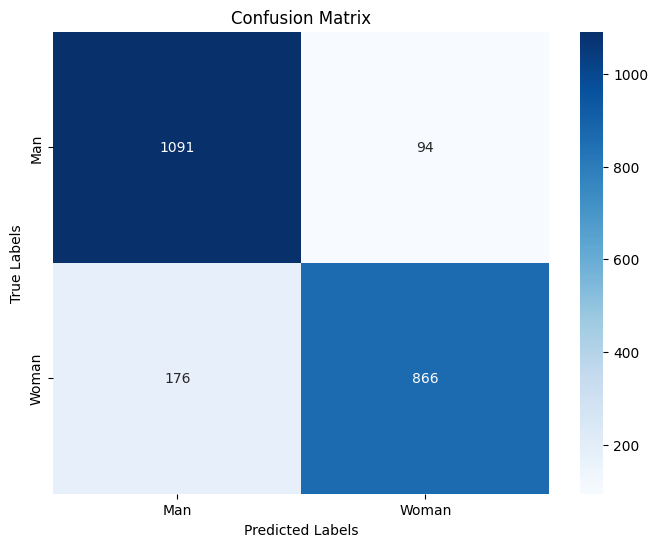

In [11]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Man", "Woman"], yticklabels=["Man", "Woman"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [1]:
# Display predictions on test images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(testX) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow((testX[idx] + 1) / 2)  # Rescale for display
    pred_label = 'Woman' if predY[idx] == 1 else 'Man'
    true_label = 'Woman' if trueY[idx] == 1 else 'Man'
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('Images/test_predictions.png')
plt.show()

NameError: name 'plt' is not defined

In [13]:
# Plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = len(H.history["loss"])
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# Save the plot to disk
plt.savefig('Images/plot.png')

NameError: name 'H' is not defined

<Figure size 640x480 with 0 Axes>